## 5. ДЗ. POS-tagger и NER
### Задание 1. Написать теггер на данных с русским языком
1. проверить UnigramTagger, BigramTagger, TrigramTagger и их комбмнации
2. написать свой теггер как на занятии, попробовать разные векторайзеры, добавить знание не только букв но и слов
3. сравнить все реализованные методы сделать выводы

In [1]:
!pip install corus
!pip install pyconll
!pip install razdel
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 897 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import nltk
from nltk.tokenize import word_tokenize
import matplotlib
%matplotlib inline

from nltk.tag import DefaultTagger
from nltk.tag import UnigramTagger, BigramTagger, TrigramTagger

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

import corus
import pandas as pd
import numpy as np

import pyconll

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !wget -O ./dataset_ru/ru_syntagrus-ud-train-a.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-a.conllu
# !wget -O ./dataset_ru/ru_syntagrus-ud-train-b.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-b.conllu
# !wget -O ./dataset_ru/ru_syntagrus-ud-train-c.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train-c.conllu
# !wget -O ./dataset_ru/ru_syntagrus-ud-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu

In [5]:
pre_path = '/content/drive/MyDrive/06_lang/05/'

full_train = pyconll.load_from_file(pre_path + 'ru_syntagrus-ud-train-a.conllu')
full_train_b = pyconll.load_from_file(pre_path + 'ru_syntagrus-ud-train-b.conllu')
full_train_c = pyconll.load_from_file(pre_path + 'ru_syntagrus-ud-train-c.conllu')

full_train.extend([*full_train_b, *full_train_c]) # объединяем

full_test = pyconll.load_from_file(pre_path + 'ru_syntagrus-ud-dev.conllu')

In [6]:
fdata_train = []
for sent in full_train[:]:
    fdata_train.append([(token.form, token.upos) for token in sent])
    
fdata_test = []
for sent in full_test[:]:
    fdata_test.append([(token.form, token.upos) for token in sent])
    
fdata_sent_test = []
for sent in full_test[:]:
    fdata_sent_test.append([token.form for token in sent])

In [7]:
comparing_list = []

### Default tagger

In [8]:
%%time

default_tagger = DefaultTagger('NOUN')

# display(default_tagger.tag(fdata_sent_test[100]))
display(default_tagger.evaluate(fdata_test))

comparing_list.append(('default_tagger', default_tagger.evaluate(fdata_test)))

0.23593983983332248

CPU times: user 413 ms, sys: 26.1 ms, total: 439 ms
Wall time: 443 ms


### Unigram Tagger

In [9]:
%%time

unigram_tagger = UnigramTagger(fdata_train)

# display(unigram_tagger.tag(fdata_sent_test[100]))
display(unigram_tagger.evaluate(fdata_test))

comparing_list.append(('unigram_tagger', unigram_tagger.evaluate(fdata_test)))

0.8782863467673677

CPU times: user 4.46 s, sys: 68.5 ms, total: 4.53 s
Wall time: 4.55 s


### Bigram Tagger

In [10]:
%%time

bigram_tagger = BigramTagger(fdata_train, backoff=unigram_tagger)

# display(bigram_tagger.tag(fdata_sent_test[100]))
display(bigram_tagger.evaluate(fdata_test))

comparing_list.append(('bigram_tagger', bigram_tagger.evaluate(fdata_test)))

0.8839768214076438

CPU times: user 8.26 s, sys: 152 ms, total: 8.41 s
Wall time: 8.42 s


### Trigram Tagger

In [11]:
%%time

trigram_tagger = TrigramTagger(fdata_train, backoff=bigram_tagger)

# display(trigram_tagger.tag(fdata_sent_test[100]))
display(trigram_tagger.evaluate(fdata_test))

comparing_list.append(('trigram_tagger', trigram_tagger.evaluate(fdata_test)))

0.8830522820496126

CPU times: user 10.9 s, sys: 106 ms, total: 11 s
Wall time: 11 s


### Taggers combination

In [12]:
from nltk.tag import TrigramTagger 

def backoff_tagger(train_sents, tagger_classes, backoff=None):
    for cls in tagger_classes:
        backoff = cls(train_sents, backoff=backoff)
    return backoff

backoff = DefaultTagger('NOUN')

In [13]:
%%time

tag = backoff_tagger(fdata_train,  
                     [UnigramTagger, BigramTagger, TrigramTagger],  
                     backoff = backoff) 
  
display(tag.evaluate(fdata_test))

comparing_list.append(('U_B_T', tag.evaluate(fdata_test)))

0.9119799466111075

CPU times: user 27.6 s, sys: 62.2 ms, total: 27.7 s
Wall time: 29.1 s


In [14]:
%%time

tag = backoff_tagger(fdata_train,  
                     [UnigramTagger, BigramTagger],  
                     backoff = backoff) 
  
display(tag.evaluate(fdata_test))

comparing_list.append(('U_B', tag.evaluate(fdata_test)))

0.9118822840028648

CPU times: user 13.5 s, sys: 30.8 ms, total: 13.5 s
Wall time: 13.5 s


In [15]:
%%time

tag = backoff_tagger(fdata_train,  
                     [BigramTagger, TrigramTagger],  
                     backoff = backoff) 
  
display(tag.evaluate(fdata_test))

comparing_list.append(('B_T', tag.evaluate(fdata_test)))

0.8606680122403803

CPU times: user 20.1 s, sys: 72.6 ms, total: 20.1 s
Wall time: 20.2 s


In [16]:
%%time

tag = backoff_tagger(fdata_train,  
                     [UnigramTagger, TrigramTagger],  
                     backoff = backoff) 
  
display(tag.evaluate(fdata_test))

comparing_list.append(('U_T', tag.evaluate(fdata_test)))

0.9119213490461618

CPU times: user 14.3 s, sys: 34.7 ms, total: 14.4 s
Wall time: 14.4 s


In [17]:
train_tok = []
train_label = []
for sent in fdata_train[:]:
    for tok in sent:
        if (tok[0] is None) or (tok[1] is None):
            continue
        train_tok.append(tok[0])
        train_label.append('NO_TAG' if tok[1] is None else tok[1])
        
test_tok = []
test_label = []
for sent in fdata_test[:]:
    for tok in sent:
        if (tok[0] is None) or (tok[1] is None):
            continue
        test_tok.append(tok[0])
        test_label.append('NO_TAG' if tok[1] is None else tok[1])

In [18]:
le = LabelEncoder()
train_enc_labels = le.fit_transform(train_label)

In [19]:
test_enc_labels = le.transform(test_label)

### Count Vectorizer

In [20]:
cvtr = CountVectorizer(ngram_range=(1, 3), analyzer='char')

X_train = cvtr.fit_transform(train_tok)
X_test = cvtr.transform(test_tok)

lr = LogisticRegression(random_state=0, n_jobs=8, max_iter=20)
lr.fit(X_train, train_enc_labels)

pred = lr.predict(X_test)
display(accuracy_score(test_enc_labels, pred))

comparing_list.append(('count_vectorizer', accuracy_score(test_enc_labels, pred)))

0.8514267079732594

### Hashing Vectorizer

In [21]:
hvtr = HashingVectorizer(ngram_range=(1, 3), analyzer='char', n_features=100)

X_train = hvtr.fit_transform(train_tok)
X_test = hvtr.transform(test_tok)

lr = LogisticRegression(random_state=0, n_jobs=8, max_iter=20)
lr.fit(X_train, train_enc_labels)

pred = lr.predict(X_test)
display(accuracy_score(test_enc_labels, pred))

comparing_list.append(('hashing_vectorizer', accuracy_score(test_enc_labels, pred)))

0.6735626936246535

CPU times: user 17 s, sys: 440 ms, total: 17.5 s
Wall time: 1min 1s


### Tfidf Vectorizer

In [22]:
tfvtr = TfidfVectorizer(ngram_range=(1, 3), analyzer='char')

X_train = tfvtr.fit_transform(train_tok)
X_test = tfvtr.transform(test_tok)

lr = LogisticRegression(random_state=0, n_jobs=8, max_iter=20)
lr.fit(X_train, train_enc_labels)

pred = lr.predict(X_test)
display(accuracy_score(test_enc_labels, pred))

comparing_list.append(('tfidf_vectorizer', accuracy_score(test_enc_labels, pred)))

0.8065416598728192

CPU times: user 16.2 s, sys: 267 ms, total: 16.4 s
Wall time: 56.3 s


In [23]:
comparing_list

[('default_tagger', 0.23593983983332248),
 ('unigram_tagger', 0.8782863467673677),
 ('bigram_tagger', 0.8839768214076438),
 ('trigram_tagger', 0.8830522820496126),
 ('U_B_T', 0.9119799466111075),
 ('U_B', 0.9118822840028648),
 ('B_T', 0.8606680122403803),
 ('U_T', 0.9119213490461618),
 ('count_vectorizer', 0.8514267079732594),
 ('hashing_vectorizer', 0.6735626936246535),
 ('tfidf_vectorizer', 0.8065416598728192)]

In [24]:
pd.DataFrame(comparing_list, columns=['tagger', 'accuracy']).sort_values(by='accuracy', ascending=False)

,tagger,accuracy
4,U_B_T,0.911980
7,U_T,0.911921
5,U_B,0.911882
2,bigram_tagger,0.883977
3,trigram_tagger,0.883052
1,unigram_tagger,0.878286
6,B_T,0.860668
8,count_vectorizer,0.851427
10,tfidf_vectorizer,0.806542
9,hashing_vectorizer,0.673563


Лучший показатель accuracy получился у комбинированного теггера, векторайзеры справились чуть хуже, ну и самый плохой показатель естественно у default_tagger.

### Задание 2. Проверить насколько хорошо работает NER
данные брать из http://www.labinform.ru/pub/named_entities/
1. проверить NER из nltk/spacy/deeppavlov
2. написать свой нер попробовать разные подходы
    * передаём в сетку токен и его соседей
    * передаём в сетку только токен
    * свой вариант
3. сравнить ваши реализованные подходы на качество (вывести precision/recall/f1_score)


In [25]:
!wget http://www.labinform.ru/pub/named_entities/collection5.zip

--2022-07-15 09:21:07--  http://www.labinform.ru/pub/named_entities/collection5.zip
Resolving www.labinform.ru (www.labinform.ru)... 95.181.230.181
Connecting to www.labinform.ru (www.labinform.ru)|95.181.230.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1899530 (1.8M) [application/zip]
Saving to: ‘collection5.zip’

collection5.zip     100%[===================>]   1.81M  2.09MB/s    in 0.9s    

2022-07-15 09:21:09 (2.09 MB/s) - ‘collection5.zip’ saved [1899530/1899530]



In [26]:
!unzip collection5.zip

Archive:  collection5.zip
   creating: Collection5/
  inflating: Collection5/001.ann     
  inflating: Collection5/001.txt     
  inflating: Collection5/002.ann     
  inflating: Collection5/002.txt     
  inflating: Collection5/003.ann     
  inflating: Collection5/003.txt     
  inflating: Collection5/004.ann     
  inflating: Collection5/004.txt     
  inflating: Collection5/005.ann     
  inflating: Collection5/005.txt     
  inflating: Collection5/006.ann     
  inflating: Collection5/006.txt     
  inflating: Collection5/007.ann     
  inflating: Collection5/007.txt     
  inflating: Collection5/008.ann     
  inflating: Collection5/008.txt     
  inflating: Collection5/009.ann     
  inflating: Collection5/009.txt     
  inflating: Collection5/010.ann     
  inflating: Collection5/010.txt     
  inflating: Collection5/011.ann     
  inflating: Collection5/011.txt     
  inflating: Collection5/012.ann     
  inflating: Collection5/012.txt     
  inflating: Collection5/013.ann    

In [27]:
from corus import load_ne5

path_coll5 = 'Collection5/'
records = load_ne5(path_coll5)
next(records)

Ne5Markup(
    id='233',
    text='Президент России уволил 6 генералов МВД\r\n \r\nПрезидент России Дмитрий Медведев продолжает перестановки в руководстве МВД. Сегодня он уволил 6 генералов милиции.\r\n\r\nВ частности, указом президента отправлен в отставку начальник Центра обеспечения оперативно-служебной деятельности по противодействию экстремизму МВД генерал-майор милиции Владимир Булатов. Не взяли на работу в полицию и ряд региональных руководителей ведомства. Уволены начальник Управления на транспорте МВД по Северо-Кавказскому федеральному округу генерал-майор милиции Игорь Жуков, начальник Управления внутренних дел по Тверской области генерал-майор милиции Александр Куликов, начальник Управления внутренних дел по Тамбовской области генерал-майор милиции Владимир Фурсов.\r\n\r\nТакже президент отправил в отставку начальников 2 милицейских институтов: начальника Сибирского юридического института МВД РФ генерал-майора милиции Николая Михайлова и начальника Тюменского юридического ин

In [28]:
from razdel import tokenize

In [29]:
words_docs = []
for ix, rec in enumerate(records):
    words = []
    for token in tokenize(rec.text):
        type_ent = 'OUT'
        for ent in rec.spans:
            if (token.start >= ent.start) and (token.stop <= ent.stop):
                type_ent = ent.type
                break
        words.append([token.text, type_ent])
    words_docs.extend(words)

In [30]:
df_words = pd.DataFrame(words_docs, columns=['word', 'tag'])

In [31]:
df_words['tag'].value_counts()
df_words.head(3)

,word,tag
0,Банк,ORG
1,России,ORG
2,лишил,OUT


In [32]:
df_words.shape

(265344, 2)

In [33]:
records = load_ne5(path_coll5)
next(records).text
next(records).text
next(records).text
next(records).text
next(records).text
article = next(records).text
article

'Кремль ждут "зачистки" после ухода В.Суркова\r\n\r\nПосле перехода бывшего замглавы администрации президента РФ Владислава Суркова на работу в правительство в Кремле ожидается "смена составов". Один из наиболее влиятельных единороссов Вячеслав Володин, который стал заместителем руководителя президентской администрации Сергея Иванова, готовит кадровые перестановки, пишет 10 января газета "РБК daily".\r\n\r\nАппарат В.Володина занимался переездом на Старую площадь непосредственно перед новогодними праздниками. Чиновникам пришлось выйти на работу еще 4 января, поскольку подчиненным нового куратора внутренней политики предстоит непосредственно заниматься подготовкой к президентским выборам.\r\n\r\nКак пишет издание со ссылкой на источник в правительстве, у В.Володина сейчас "мало своих людей". Ближайшими к нему персонами считаются его земляки из Саратова – директор департамента госслужбы и кадров Иван Лобанов и глава думского аграрного комитета Николай Панков, а также ректор РЭУ им.Плехан

NLTK

In [34]:
import nltk
nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.download('names')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [35]:
words5 = list(df_words.word)

In [36]:
data5_tag = nltk.pos_tag(words5[:50000])

In [37]:
{(' '.join(c[0] for c in chunk), chunk.label() ) for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(article))) if hasattr(chunk, 'label') }

{('Виктор Грищин', 'PERSON'),
 ('Костин', 'PERSON'),
 ('Кремле', 'PERSON'),
 ('Кремль', 'GPE'),
 ('Кремль', 'PERSON'),
 ('Лобанов', 'PERSON'),
 ('Николай Панков', 'PERSON'),
 ('РБК', 'ORGANIZATION'),
 ('Сергей Неверов', 'PERSON'),
 ('Сергея Иванова', 'PERSON'),
 ('Старую', 'PERSON'),
 ('Суркова', 'PERSON'),
 ('Хабиров', 'PERSON')}

NLTK справился ужасно))

Spacy

In [38]:
!python -m spacy download ru_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 1.3 MB/s 
     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 8.2 MB 8.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [39]:
import spacy
from spacy import displacy

In [40]:
nlp = spacy.load("ru_core_news_sm")
spacy_article = nlp(article)
displacy.render(spacy_article, jupyter=True, style='ent')

Spacy неплохо справился

Deeppaclov

In [41]:
!pip install deeppavlov

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 878 kB 5.2 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 654 kB 45.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |████████████████████████████████| 1.5 MB 52.7 MB/s 
     |████████████████████████████████| 65 kB 4.5 MB/s 
     |████████████████████████████████| 6.7 MB 18.2 MB/s 
     |████████████████████████████████| 76 kB 5.2 MB/s 
     |████████████████████████████████| 26.1 MB 68.2 MB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 2.9 MB 39.3 MB/s 
     |████████████████████████████████| 10.4 MB 27.3 MB/s 
     |████████████████████████████████| 55 kB 5.3 MB/s 
     |████████████████████████████████| 7.3 MB 32.5 MB/s 
     |████████████████████████████████| 85

In [42]:
# !python -m deeppavlov install ner_rus_bert_torch

# !python -m venv env 
# #.\env\Scripts\activate.bat
# !pip install deeppavlov
# !python -m deeppavlov install squad_bert

#!python -m deeppavlov install ner_ontonotes

In [ ]:
# !pip install tensorflow-gpu==1.14.0

In [43]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.6 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3141299 sha256=f8919b515870a555a4d3698c6ebbf447df596d82771c98f3f88392c40c84bacf
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [51]:
import deeppavlov
from deeppavlov import configs, build_model
deeppavlov_ner = build_model(configs.ner, download=True)
rus_document = "Нью-Йорк, США, 30 апреля 2020, 01:01 — REGNUM В администрации президента США Дональда Трампа планируют пройти все этапы создания вакцины от коронавируса в ускоренном темпе и выпустить 100 млн доз до конца 2020 года, передаёт агентство Bloomberg со ссылкой на осведомлённые источники"
deeppavlov_ner([rus_document])

AttributeError: ignored

Deeppavlov устанавливается через одно место даже на колаб, некогда возиться

Natasha

In [45]:
!pip install natasha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.4 MB 59 kB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 41 kB 117 kB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=28ba63353bbce1ef6ed0938e2fc65ac8ec3a850a0595b673cefc1110f903b048
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


In [46]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

In [52]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '
doc = Doc(article)

In [53]:
doc.segment(segmenter)
display(doc.tokens[:5])
display(doc.sents[:5])

[DocToken(stop=6, text='Кремль'),
 DocToken(start=7, stop=11, text='ждут'),
 DocToken(start=12, stop=13, text='"'),
 DocToken(start=13, stop=21, text='зачистки'),
 DocToken(start=21, stop=22, text='"')]

[DocSent(stop=189, text='Кремль ждут "зачистки" после ухода В.Суркова\r\n\..., tokens=[...]),
 DocSent(start=190, stop=398, text='Один из наиболее влиятельных единороссов Вячеслав..., tokens=[...]),
 DocSent(start=402, stop=505, text='Аппарат В.Володина занимался переездом на Старую ..., tokens=[...]),
 DocSent(start=506, stop=687, text='Чиновникам пришлось выйти на работу еще 4 января,..., tokens=[...]),
 DocSent(start=691, stop=788, text='Как пишет издание со ссылкой на источник в правит..., tokens=[...])]

In [54]:
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
doc.parse_syntax(syntax_parser)
sent = doc.sents[0]
sent.morph.print()

              Кремль PROPN|Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing
                ждут VERB|Aspect=Imp|Mood=Ind|Number=Plur|Person=3|Tense=Pres|VerbForm=Fin|Voice=Act
                   " PUNCT
            зачистки NOUN|Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing
                   " PUNCT
               после ADP
               ухода NOUN|Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing
                   В PROPN|Animacy=Anim|Case=Gen|Gender=Masc|Number=Sing
                   . PUNCT
             Суркова PROPN|Animacy=Anim|Case=Gen|Gender=Masc|Number=Sing
               После ADP
            перехода NOUN|Animacy=Inan|Case=Gen|Gender=Masc|Number=Sing
             бывшего ADJ|Case=Gen|Degree=Pos|Gender=Masc|Number=Sing
            замглавы NOUN|Animacy=Anim|Case=Gen|Gender=Masc|Number=Sing
       администрации NOUN|Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing
          президента NOUN|Animacy=Anim|Case=Gen|Gender=Masc|Number=Sing
                  РФ PROPN|Animacy=Inan|Case=Gen|G

In [55]:
sent.syntax.print()

              ┌► Кремль        obj
┌─┌─────┌─┌─┌─└─ ждут          
│ │     │ │ │ ┌► "             punct
│ │     │ │ └►└─ зачистки      obj
│ │     │ │ └──► "             punct
│ │     │ │   ┌► после         case
│ │     │ └►┌─└─ ухода         obl
│ │     │   └►┌─ В             nmod
│ │ ┌──►│     │  .             punct
│ │ │   │     └► Суркова       flat:name
│ │ │   │     ┌► После         case
│ │ │ ┌─└──►┌─└─ перехода      obl
│ │ │ │     │ ┌► бывшего       amod
│ │ │ │   ┌─└►└─ замглавы      nmod
│ │ │ │   │ └►┌─ администрации nmod
│ │ │ │   │ ┌─└► президента    nmod
│ │ │ │   │ └──► РФ            nmod
│ │ │ │   └──►┌─ Владислава    appos
│ │ │ │       └► Суркова       flat:name
│ │ │ │       ┌► на            case
│ └►│ │       └─ работу        obl
│   │ │       ┌► в             case
│   │ └──────►└─ правительство nmod
│   │         ┌► в             case
│   │       ┌►└─ Кремле        obl
│   └─────┌─└─── ожидается     
│         │   ┌► "             punct
│       ┌─└►┌─└─ смена     

In [56]:
doc.tag_ner(ner_tagger)
doc.ner.print()

Кремль ждут "зачистки" после ухода В.Суркова
LOC───                             PER──────
После перехода бывшего замглавы администрации президента РФ Владислава
                                                         LO PER───────
 Суркова на работу в правительство в Кремле ожидается "смена 
────────                             LOC───                  
составов". Один из наиболее влиятельных единороссов Вячеслав Володин, 
                                                    PER─────────────  
который стал заместителем руководителя президентской администрации 
Сергея Иванова, готовит кадровые перестановки, пишет 10 января газета 
PER───────────                                                        
"РБК daily".
 ORG──────  
Аппарат В.Володина занимался переездом на Старую площадь 
        PER───────                        LOC─────────── 
непосредственно перед новогодними праздниками. Чиновникам пришлось 
выйти на работу еще 4 января, поскольку подчиненным нового куратора 
внутренней по

Natasha справилась тоже довольно неплохо

## Создадим свой NER


In [57]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D, GRU, LSTM, Dropout, Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [58]:
from sklearn import model_selection, preprocessing, linear_model

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(df_words['word'], df_words['tag'])

# labelEncode целевую переменную
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [59]:
train_x.apply(len).max(axis=0)

55

In [60]:
# char level
#train_x = train_x.apply(lambda x: ' '.join(list(x)))
#valid_x = valid_x.apply(lambda x: ' '.join(list(x)))

In [61]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

train_data = train_data.batch(16)
valid_data = valid_data.batch(16)

In [62]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

### Униграмы

In [63]:
def custom_standardization(input_data):
    return input_data

vocab_size = 30000
seq_len = 10

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    #ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [64]:
len(vectorize_layer.get_vocabulary())

30000

In [65]:
embedding_dim = 64

class modelNER(tf.keras.Model):
    def __init__(self):
        super(modelNER, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim)
        self.gPool = GlobalMaxPooling1D()
        self.fc1 = Dense(300, activation='relu')
        self.fc2 = Dense(50, activation='relu')
        self.fc3 = Dense(6, activation='softmax')

    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        pool_x = self.gPool(x)
        
        fc_x = self.fc1(pool_x)
        fc_x = self.fc2(fc_x)
        
        concat_x = tf.concat([pool_x, fc_x], axis=1)
        prob = self.fc3(concat_x)
        return prob

In [66]:
mmodel = modelNER()

In [67]:
mmodel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [68]:
mmodel.fit(train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12438/12438 [==============================] - 252s 20ms/step - loss: 0.2933 - accuracy: 0.9142 - val_loss: 0.3066 - val_accuracy: 0.9392
Epoch 2/3
12438/12438 [==============================] - 248s 20ms/step - loss: 0.1247 - accuracy: 0.9627 - val_loss: 0.3209 - val_accuracy: 0.9422
Epoch 3/3
12438/12438 [==============================] - 250s 20ms/step - loss: 0.1088 - accuracy: 0.9656 - val_loss: 0.3107 - val_accuracy: 0.9417


In [75]:
preds = mmodel.predict(valid_x)
preds = np.argmax(preds,axis=1)

In [76]:
print(classification_report(valid_y, preds))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1048
           1       0.84      0.76      0.80      1164
           2       0.94      0.76      0.84       622
           3       0.91      0.53      0.67      3363
           4       0.94      0.99      0.97     54913
           5       0.98      0.72      0.83      5226

    accuracy                           0.94     66336
   macro avg       0.91      0.78      0.83     66336
weighted avg       0.94      0.94      0.94     66336



In [88]:
classes = encoder.classes_
classes

array(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'], dtype=object)

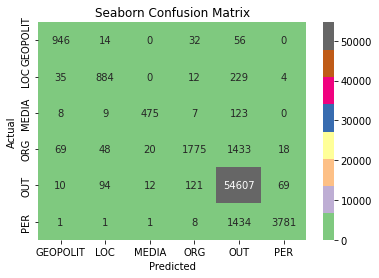

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(valid_y, preds)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])

plt.show()

### Изменим векторайзер, добавив биграмы

In [87]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    ngrams=(1, 2),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)
mmodel_bi = modelNER()
mmodel_bi.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

mmodel_bi.fit( train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12438/12438 [==============================] - 347s 28ms/step - loss: 0.2970 - accuracy: 0.9132 - val_loss: 0.3086 - val_accuracy: 0.9391
Epoch 2/3
12438/12438 [==============================] - 374s 30ms/step - loss: 0.1258 - accuracy: 0.9625 - val_loss: 0.3177 - val_accuracy: 0.9419
Epoch 3/3
12438/12438 [==============================] - 294s 24ms/step - loss: 0.1096 - accuracy: 0.9655 - val_loss: 0.3127 - val_accuracy: 0.9419


              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1048
           1       0.84      0.76      0.80      1164
           2       0.94      0.77      0.85       622
           3       0.88      0.55      0.68      3363
           4       0.94      0.99      0.97     54913
           5       0.98      0.72      0.83      5226

    accuracy                           0.94     66336
   macro avg       0.91      0.78      0.84     66336
weighted avg       0.94      0.94      0.94     66336



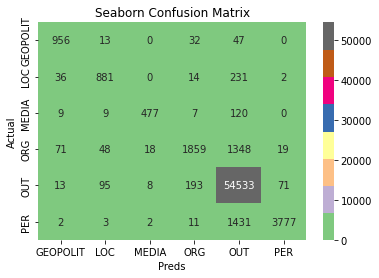

In [89]:
preds_bi = mmodel_bi.predict(valid_x)
preds_bi = np.argmax(preds_bi,axis=1)

print(classification_report(valid_y, preds_bi))

cm = confusion_matrix(valid_y, preds_bi)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Preds')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])

plt.show()

### Изменим векторайзер, добавив биграмы и триграмы, и длину последовательности 100.


In [90]:
seq_len = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    ngrams=(1, 3),
    output_sequence_length=seq_len)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)
mmodel_three = modelNER()
mmodel_three.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

mmodel_three.fit( train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
12438/12438 [==============================] - 315s 25ms/step - loss: 0.2943 - accuracy: 0.9142 - val_loss: 0.2880 - val_accuracy: 0.9388
Epoch 2/3
12438/12438 [==============================] - 283s 23ms/step - loss: 0.1248 - accuracy: 0.9628 - val_loss: 0.2978 - val_accuracy: 0.9424
Epoch 3/3
12438/12438 [==============================] - 289s 23ms/step - loss: 0.1093 - accuracy: 0.9657 - val_loss: 0.2908 - val_accuracy: 0.9421


              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1048
           1       0.85      0.75      0.80      1164
           2       0.94      0.77      0.84       622
           3       0.89      0.55      0.68      3363
           4       0.94      0.99      0.97     54913
           5       0.98      0.72      0.83      5226

    accuracy                           0.94     66336
   macro avg       0.91      0.78      0.84     66336
weighted avg       0.94      0.94      0.94     66336



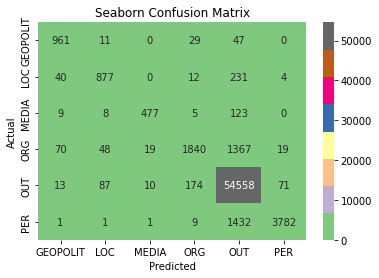

In [91]:
preds_three = mmodel_three.predict(valid_x)
preds_three = np.argmax(preds_three,axis=1)

print(classification_report(valid_y, preds_three))

cm = confusion_matrix(valid_y, preds_three)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Accent")

ax.set_title('Seaborn Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

## For the Tick Labels, the labels should be in Alphabetical order
ax.xaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])
ax.yaxis.set_ticklabels(['GEOPOLIT', 'LOC', 'MEDIA', 'ORG', 'OUT', 'PER'])

plt.show()

Самописная NER в принципе неплохо справляется. Есть небольшое улучшение, когда даем сетке токен и соседей, по сравнению с тем, когда даем сетке только токен.